[View in Colaboratory](https://colab.research.google.com/github/denisparra/pyreclab_tutorial/blob/master/pyreclab_CF_Slope1.ipynb)

# Practica Pyreclab 1

En este práctico vamos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab) desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile, para aprender sobre algoritmos básicos y tradicionales de sistemas de recomendacion:


*   Most Popular
*   Item Average Rating
*   User KNN (Filtrado colaborativo basado en usuarios)
*   Item KNN (Filtrado colaborativo basado en items)
*   FunkSVD (Factorización matricial SVD regularizada)


**Autores**: Denis Parra, Gabriel Sepúlveda


**Nombre**:  tu nombre aqui

#Instrucciones

Vaya ejecutando cada celda presionand el botón de Play o presionando Ctrl+Enter (Linux y Windows) o Command+Enter (Macosx)

In [1]:
!curl -L -o "u1.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    388      0 --:--:-- --:--:-- --:--:--  1037
100 1546k  100 1546k    0     0  1546k      0  0:00:01  0:00:01 --:--:-- 1546k


In [2]:
!curl -L -o "u1.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    388      0 --:--:-- --:--:-- --:--:--  1099
100  385k  100  385k    0     0   385k      0  0:00:01 --:--:--  0:00:01 75.3M


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    388      0 --:--:-- --:--:-- --:--:--   838
100  230k  100  230k    0     0   230k      0  0:00:01 --:--:--  0:00:01  230k


Los archivos u1.base y u1.test tienen tuplas {usuario, item, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [movielens](https://grouplens.org/datasets/movielens/).

Revisemos cómo es uno de estos archivos:

In [4]:
import pandas as pd

train_file = pd.read_csv('u1.base', sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


Por otra parte, para obtener información adicional de cada película tal como *título*, *fecha de lanzamient*o, *género*, etc., cargaremos el archivo de items descargado ( *u.item* ) para poder mapear cada identificador de ítem al conjunto de datos que lo describe.
Revisemos el contenido de este archivo

In [5]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

info_file = pd.read_csv('u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')
#info_file = pd.read_csv('u.item', sep='|',  names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
info_file.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

 2.- Instalar ***pyreclab***

In [7]:
!pip install pyreclab

    100% |████████████████████████████████| 153kB 6.8MB/s 


3..- Importar pyreclab y numpy

In [0]:
import pyreclab
import numpy as np

4.- Probar método de recomendación basado en ***Most Popular***

In [0]:
# declarar el objeto recomendador de la clase MostPopular
mymp = pyreclab.MostPopular(dataset = 'u1.base',dlmchar = b'\t',header = False,usercol = 0,itemcol = 1, ratingcol = 2 )


In [0]:
# entrenamos el modelo con los datos existentes

# el método calcula el numero de veces que fue consumido cada item, 
# así, puede luego recomendar los mas populares
mymp.train()

In [11]:
# con este método no podemos predecir ratings, pero sí podemos recomendar
# la recomendación es no personalizada (igual recomendación a todos los usuarios)
reclist = mymp.recommend("457")
print(reclist)

['50', '100', '258', '181', '286', '1', '174', '127', '7', '98']


In [12]:
# con esto podemos ver las recomendaciones con titulo de película
pelis = np.array(reclist).astype(int)
info_file.loc[pelis]['title']

movieid
50                     Star Wars (1977)
100                        Fargo (1996)
258                      Contact (1997)
181           Return of the Jedi (1983)
286         English Patient, The (1996)
1                      Toy Story (1995)
174      Raiders of the Lost Ark (1981)
127               Godfather, The (1972)
7                 Twelve Monkeys (1995)
98     Silence of the Lambs, The (1991)
Name: title, dtype: object

5.- Probar método de recomendación basado en ***ItemAvg***

In [0]:
# declarar el objeto recomendador ItemAvg
myitemavg = pyreclab.ItemAvg(dataset = 'u1.base',dlmchar = b'\t',header = False,usercol = 0,itemcol = 1, ratingcol = 2 )


In [0]:
# entrenamos el modelo con los datos existentes
myitemavg.train()

¿Qué cree usted que hace la función train() del método de recomendación ItemAvg() ?

Respuesta:

In [0]:
# Predecir rating que el usuario ID 457 le dará al ítem ID 37
myitemavg.predict("457","37")

Ejecute el mismo comando anterior para predecir esta vez el rating que el usuario 498 dará al item 37 ¿Qué rating da? ¿Cómo se explica este resultado?

Respuesta:

In [0]:
# Generar lista de 5 recomendaciones para el usuario con ID 457

reclist_iavg = myitemavg.recommend("457",5)
print(reclist_iavg)

Genere una lista de 11 recomendaciones para el usario ID 478 ¿Cómo se explican las recomendaciones del método para este usuario comparadas con las del usuario 457?

In [0]:
# genera aqui las recomendacion para el usuario 478



Respuesta: 

¿Cuáles son los títulos de las películas recomendadas por el método **ItemAvg ** para el usuario 457 ? ¿Qué le parecen estas recomendaciones comparadas con el método **MostPopular**?

In [0]:
# (pista) recuerde los comandos usados en el método anterior

# pelis = np.array(reclist).astype(int)
# info_file.loc[pelis]['title']

6.- Probar método de recomendación basado en ***UserKNN***

In [0]:
# declarar el objeto recomendador UserKnn
myUserKnn = pyreclab.UserKnn(dataset = 'u1.base',dlmchar = b'\t',header = False,usercol = 0,itemcol = 1, ratingcol = 2 )


In [0]:
# entrenamos el modelo con los datos existentes
# recuerde que en este metodo puede probar el parámetro k de cantidad de vecinos
# así como la métrica de similaridad (pearson, cosine)
myUserKnn.train(7,'pearson')

In [0]:
# Predecir rating que el usuario ID 457 le dará al ítem ID 37
myUserKnn.predict( ,  )

Según el modelo de recomendación UserKnn, qué rating le dará el usuario 457 al item 37 ?

Respuesta: 

In [0]:
# Generar lista de recomendaciones 6 para el usuario con ID 457

reclist_uknn = myUserKnn.recommend("457",5)
print(reclist_uknn)


Escriba los nombres de las películas recomendadas por el método knn

Respuesta: 

In [0]:
# (pista) recuerde los comandos usados en el método anterior

# pelis = np.array(reclist_uknn).astype(int)
# info_file.loc[pelis]['title']

In [0]:
# Evaluar en base a error de prediccion (RMSE)

k_values = [5, 10, 30, 50] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  
  myUserKnn.train(k,'cosine')
  predlist, mae, rmse = myUserKnn.test( input_file = 'u1.test',dlmchar = b'\t', header = False, usercol = 0, itemcol = 1, ratingcol = 2, output_file = 'predictions.csv' )
  rmse_values.append(rmse)   
  

In [0]:
print(rmse_values)

[1.0006176712631452, 0.985968197022971, 0.9771025822148011, 0.9727805377805858]


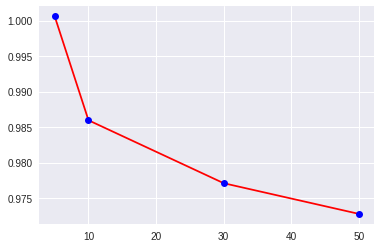

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.show()

Según los resultados: ¿ qué numero de vecinos es mejor para hacer recomendaciones con un menor error de predicción ?

7.- Probar método de recomendación basado en ***ItemKNN***

Replicar todo el análisis de UserKNN con el método ItemKNN

8.- Probar método de recomendación basado en ***SlopeOne***

Replicar todo el análisis de UserKNN con el método SlopeOne
